**Databled Team DHL Datathon First Case**

***

19-24 October

***

- Berkay Alan

- Fahri Bilici

- Özgür Cem Taş

In [177]:
import requests
import json
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

In [111]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

## Case

DHL gibi kontrat lojistiği hizmeti sağlayan firmalarda belirli periyotlarda müşterinin ürün gamının ihtiyaçları ve kısıtları gözetilerek sözleşmeler yapılır. Bu sözleşmelerden önce gelir/gider tahminlemelerinin yapılabilmesi için hacim tahminlemeleri oldukça kritiktir.  Bu nedenle, yarışmanın ilk aşamasında, 2021 yılı ilk 9 haftasına ilişkin siparişlerin ürün ve müşteri bazında Hacim Tahminlemesi yapılması beklenmektedir. Konu ile ilgili detay bilgiye https://datathon.dhlrdlab.com/ adresinden ulaşabilirsiniz. 

Söz konusu tahminleme modeli için train_set.csv, test_set.csv ve submission.csv olmak üzere 3 farklı csv dosyası paylaşılmıştır. Test verisi üzerinde yapmış olduğunuz tahmin sonuçlarınızın submission.csv formatında yüklenmesi beklenmektir.

***

**train_set.csv**:

•	Sipariş Numarası: Her siparişe ait unique ID.

•	Sipariş Satırı: Aynı “Sipariş Numarası” içinde sipariş edilen ürünlerin satır numarası.  (Aynı siparişe ilişkin farklı ürünleri belirtilen satır numarası olarak değerlendirilebilir)

•	Sipariş Tipi: Sevk edilecek siparişin tipi.

•	Malzeme Numarası: Ürüne ait unique ID.

•	Sipariş Edilen Miktar: Ürüne ait sipariş miktarı.

•	Sku Plt. Standartı: Her ürüne ait bir palete yüklenebilecek ürün miktarı. (ürünün boyutlarına göre değişkenlik gösterir)

•	Müşteri No: Siparişin sevk edileceği müşteriye ait unique ID.

•	Sipariş Tarihi: Siparişin DHL depo yönetim sistemindeki tarihi. (Yıl – Ay- Gün formatında)

***

**submission.csv:**


•	yılhafta: Siparişin DHL depo yönetim sistemindeki tarihi (“yılhafta” şeklinde bitişik yazılmış formatta)	 
•	Malzeme Numarası: Ürüne ait unique ID.
•	Müşteri: Siparişin sevk edileceği müşteriye ait unique ID.


## Reading Files

In [573]:
train = pd.read_csv("train_set.csv",parse_dates=["Sipariş Tarihi"])
test = pd.read_csv("test_set.csv",parse_dates=["Sipariş Tarihi"])
submission = pd.read_csv("submission.csv")

In [574]:
train.head()

,Sipariş Numarası,Sipariş Satırı,Sipariş Tipi,Malzeme Numarası,Sipariş Edilen Miktar,Sku Plt. Standartı,Müşteri No,Sipariş Tarihi
0,72616887,1,Müşteri Siparişleri,61001960,60,228,C-10008,2020-01-02
1,72616888,1,Müşteri Siparişleri,61000066,25,96,C-10185,2020-01-02
2,72616888,2,Müşteri Siparişleri,61001960,50,228,C-10185,2020-01-02
3,72616889,1,Müşteri Siparişleri,61000066,40,96,C-10188,2020-01-02
4,72616889,2,Müşteri Siparişleri,61001960,20,228,C-10188,2020-01-02


In [575]:
train.shape

(276753, 8)

In [576]:
test.head()

,Sipariş Numarası,Sipariş Satırı,Sipariş Tipi,Malzeme Numarası,Sku Plt. Standartı,Müşteri No,Sipariş Tarihi
0,72666244,1,Paketli Siparişler,CN05756A,36,C-10005,2021-01-03
1,72666256,1,Müşteri Siparişleri,TR02237A,160,C-10176,2021-01-04
2,72666257,1,Müşteri Siparişleri,61013510,240,C-10154,2021-01-04
3,72666259,1,Müşteri Siparişleri,61013508,364,C-10160,2021-01-04
4,72666265,1,Müşteri Siparişleri,TR02237A,160,C-10024,2021-01-04


In [577]:
train["Sipariş Tipi"].value_counts()

Müşteri Siparişleri    275183
Paketli Siparişler       1507
Transfer                   63
Name: Sipariş Tipi, dtype: int64

In [578]:
train["Malzeme Numarası"].value_counts().sort_values(ascending=False)[:10]

61001960    7252
PL07760A    5710
TR02285A    5699
TR01575A    5434
PL08273A    4042
CN07510A    4034
TR01822B    3898
TR01824B    3541
TR01164A    3262
TR01066B    3082
Name: Malzeme Numarası, dtype: int64

In [579]:
train["Sipariş Tarihi"].min()

Timestamp('2020-01-02 00:00:00')

In [580]:
train["Sipariş Tarihi"].max()

Timestamp('2020-12-30 00:00:00')

In [581]:
test["Sipariş Tarihi"].min()

Timestamp('2021-01-03 00:00:00')

In [582]:
test["Sipariş Tarihi"].max()

Timestamp('2021-02-27 00:00:00')

In [583]:
train["week"]=train["Sipariş Tarihi"].apply(lambda x: x.week)

In [584]:
train["year"]=train["Sipariş Tarihi"].apply(lambda x: x.year)

In [585]:
test["week"]=test["Sipariş Tarihi"].apply(lambda x: x.week)

In [586]:
test["year"]=test["Sipariş Tarihi"].apply(lambda x: x.year)

In [587]:
train["month"]=train["Sipariş Tarihi"].apply(lambda x: x.month)

In [588]:
test["month"]=test["Sipariş Tarihi"].apply(lambda x: x.month)

In [589]:
train['yılhafta'] = train["Sipariş Tarihi"].map(lambda x: '{yıl}{hafta:02}'.format(yıl=x.year,hafta=x.week))

In [590]:
test['yılhafta'] = test["Sipariş Tarihi"].map(lambda x: '{yıl}{hafta:02}'.format(yıl=x.year,hafta=x.week))

In [592]:
test

,Sipariş Numarası,Sipariş Satırı,Sipariş Tipi,Malzeme Numarası,Sku Plt. Standartı,Müşteri No,Sipariş Tarihi,week,year,month,yılhafta
0,72666244,1,Paketli Siparişler,CN05756A,36,C-10005,2021-01-03,53,2021,1,202153
1,72666256,1,Müşteri Siparişleri,TR02237A,160,C-10176,2021-01-04,1,2021,1,202101
2,72666257,1,Müşteri Siparişleri,61013510,240,C-10154,2021-01-04,1,2021,1,202101
3,72666259,1,Müşteri Siparişleri,61013508,364,C-10160,2021-01-04,1,2021,1,202101
4,72666265,1,Müşteri Siparişleri,TR02237A,160,C-10024,2021-01-04,1,2021,1,202101
...,...,...,...,...,...,...,...,...,...,...,...
46931,72674481,12,Müşteri Siparişleri,FCN01816,280,C-10028,2021-02-27,8,2021,2,202108
46932,72674483,11,Müşteri Siparişleri,PL07963A,300,C-10012,2021-02-27,8,2021,2,202108
46933,72674483,23,Müşteri Siparişleri,61003831,60,C-10012,2021-02-27,8,2021,2,202108
46934,72674488,12,Müşteri Siparişleri,61003464,144,C-10001,2021-02-27,8,2021,2,202108


In [516]:
train.isna().sum()

Sipariş Numarası         0
Sipariş Satırı           0
Sipariş Tipi             0
Malzeme Numarası         0
Sipariş Edilen Miktar    0
Sku Plt. Standartı       0
Müşteri No               0
Sipariş Tarihi           0
week                     0
year                     0
month                    0
dtype: int64

In [517]:
train["Sipariş Numarası"].nunique()

37085

In [518]:
train.groupby(["Sipariş Numarası","Malzeme Numarası"]).sum(["Sipariş Edilen Miktar"])

Sipariş Satırı  Sipariş Edilen Miktar  Sku Plt. Standartı  week  year  month
Sipariş Numarası Malzeme Numarası                                                                              
72616887         61001960                       1                     60                 228     1  2020      1
72616888         61000066                       1                     25                  96     1  2020      1
                 61001960                       2                     50                 228     1  2020      1
72616889         61000066                       1                     40                  96     1  2020      1
                 61001960                       2                     20                 228     1  2020      1
...                                           ...                    ...                 ...   ...   ...    ...
72666126         61007050                       1                   2376                  72    53  2020     12
72666165         PL08105A                       1                  12012                 185    53  2020     12
72666166         PL08105A                       1                  12210                 185    53  2020     12
72666197         PL08105A                       1                  11837                 185    53  2020     12
72666198         PL08105A                       1                  12210                 185    53  2020     12

[256677 rows x 6 columns]

In [519]:
train.groupby(["Malzeme Numarası"]).sum()["Sipariş Edilen Miktar"]

Malzeme Numarası
10000000          6539
10000692            42
10187005           365
278515            1351
282525             455
61000058         17489
61000066        109942
61000192         11553
61000202          3083
61000267         38291
61000354           128
61000404         21999
61000455          8282
61000458         15560
61000757         70859
61000758         70402
61000759         28724
61000760         45000
61000761         63261
61000762         94288
61000763         62169
61000764         13724
61000766         10858
61000767           737
61000969           946
61000978          4948
61000992          3333
61001069         20355
61001071         11225
61001072         12691
61001294           189
61001307          6706
61001309          3579
61001314           710
61001315          1035
61001422         39117
61001728          6506
61001807         17213
61001903          1168
61001960        396585
61002841         11750
61002995         16593
61003229         

In [520]:
test.head()

,Sipariş Numarası,Sipariş Satırı,Sipariş Tipi,Malzeme Numarası,Sku Plt. Standartı,Müşteri No,Sipariş Tarihi,week,year,month
0,72666244,1,Paketli Siparişler,CN05756A,36,C-10005,2021-01-03,53,2021,1
1,72666256,1,Müşteri Siparişleri,TR02237A,160,C-10176,2021-01-04,1,2021,1
2,72666257,1,Müşteri Siparişleri,61013510,240,C-10154,2021-01-04,1,2021,1
3,72666259,1,Müşteri Siparişleri,61013508,364,C-10160,2021-01-04,1,2021,1
4,72666265,1,Müşteri Siparişleri,TR02237A,160,C-10024,2021-01-04,1,2021,1


In [521]:
test.shape

(46936, 10)

In [522]:
test["Sipariş Numarası"].nunique()

6107

## Feature Engineering

### Adding Covid Features

Adding to Train

In [447]:
covid = pd.read_excel("Turkey Coronavirüs Dataset.xlsx")
covid=covid[200:496].sort_index(ascending=False)

In [448]:
covid=covid.fillna(0)
covid.iloc[:,1:] = covid.iloc[:,1:].astype(int)

In [449]:
merged_train= pd.merge(train,covid,how="left",left_on="Sipariş Tarihi",right_on="Date")

In [450]:
merged_train.drop("Date",axis=1,inplace=True)
merged_train=merged_train.fillna(0)
merged_train.iloc[:,10:] = merged_train.iloc[:,10:].astype(int)

In [451]:
merged_train.head()

,Sipariş Numarası,Sipariş Satırı,Sipariş Tipi,Malzeme Numarası,Sipariş Edilen Miktar,Sku Plt. Standartı,Müşteri No,Sipariş Tarihi,week,year,month,Total Number of Tests,Total Number of Patiens,Total Number of Deaths,Pneumonia Rate in Patients (%),The Number of Seriously Ill Patients,Total Number of Recovered Patients,Number of Cases Today,Number of Patients for Today,Number of Tests for Today,Number of Deaths for Today,Number of Recovered Patients for Today
0,72616887,1,Müşteri Siparişleri,61001960,60,228,C-10008,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0
1,72616888,1,Müşteri Siparişleri,61000066,25,96,C-10185,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0
2,72616888,2,Müşteri Siparişleri,61001960,50,228,C-10185,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0
3,72616889,1,Müşteri Siparişleri,61000066,40,96,C-10188,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0
4,72616889,2,Müşteri Siparişleri,61001960,20,228,C-10188,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0


Adding to Test

In [452]:
covid = pd.read_excel("Turkey Coronavirüs Dataset.xlsx")
covid=covid[131:200].sort_index(ascending=False)

In [453]:
covid.iloc[:,1:] = covid.iloc[:,1:].astype(int)

In [454]:
merged_test= pd.merge(test,covid,how="left",left_on="Sipariş Tarihi",right_on="Date")

In [455]:
merged_test.drop("Date",axis=1,inplace=True)

In [456]:
merged_test.head()

,Sipariş Numarası,Sipariş Satırı,Sipariş Tipi,Malzeme Numarası,Sku Plt. Standartı,Müşteri No,Sipariş Tarihi,week,year,month,Total Number of Tests,Total Number of Patiens,Total Number of Deaths,Pneumonia Rate in Patients (%),The Number of Seriously Ill Patients,Total Number of Recovered Patients,Number of Cases Today,Number of Patients for Today,Number of Tests for Today,Number of Deaths for Today,Number of Recovered Patients for Today
0,72666244,1,Paketli Siparişler,CN05756A,36,C-10005,2021-01-03,53,2021,1,24950829,2241912,21488,3,3612,2136534,9877,1515,138941,193,10102
1,72666256,1,Müşteri Siparişleri,TR02237A,160,C-10176,2021-01-04,1,2021,1,25132152,2255607,21685,4,3522,2146430,13695,1508,181323,197,9896
2,72666257,1,Müşteri Siparişleri,61013510,240,C-10154,2021-01-04,1,2021,1,25132152,2255607,21685,4,3522,2146430,13695,1508,181323,197,9896
3,72666259,1,Müşteri Siparişleri,61013508,364,C-10160,2021-01-04,1,2021,1,25132152,2255607,21685,4,3522,2146430,13695,1508,181323,197,9896
4,72666265,1,Müşteri Siparişleri,TR02237A,160,C-10024,2021-01-04,1,2021,1,25132152,2255607,21685,4,3522,2146430,13695,1508,181323,197,9896


### Adding The Weather

In [457]:
weather_istanbul = pd.read_csv("weather_istanbul_2.csv")

In [458]:
weather_istanbul=weather_istanbul.iloc[:,1:5]

In [459]:
weather_istanbul=weather_istanbul.rename({"SNWD":"Snow","TAVG":"Rain"},axis=1)

In [460]:
weather_istanbul.DATE=pd.to_datetime(weather_istanbul.DATE)

In [461]:
merged_train= pd.merge(merged_train,weather_istanbul,how="left",left_on="Sipariş Tarihi",right_on="DATE")

In [462]:
merged_train.drop("DATE",axis=1,inplace=True)

In [463]:
merged_test= pd.merge(merged_test,weather_istanbul,how="left",left_on="Sipariş Tarihi",right_on="DATE")

In [464]:
merged_test.drop("DATE",axis=1,inplace=True)

In [465]:
merged_test.head()

,Sipariş Numarası,Sipariş Satırı,Sipariş Tipi,Malzeme Numarası,Sku Plt. Standartı,Müşteri No,Sipariş Tarihi,week,year,month,Total Number of Tests,Total Number of Patiens,Total Number of Deaths,Pneumonia Rate in Patients (%),The Number of Seriously Ill Patients,Total Number of Recovered Patients,Number of Cases Today,Number of Patients for Today,Number of Tests for Today,Number of Deaths for Today,Number of Recovered Patients for Today,PRCP,Snow,Rain
0,72666244,1,Paketli Siparişler,CN05756A,36,C-10005,2021-01-03,53,2021,1,24950829,2241912,21488,3,3612,2136534,9877,1515,138941,193,10102,0.0,NaN,13.1
1,72666256,1,Müşteri Siparişleri,TR02237A,160,C-10176,2021-01-04,1,2021,1,25132152,2255607,21685,4,3522,2146430,13695,1508,181323,197,9896,NaN,NaN,14.3
2,72666257,1,Müşteri Siparişleri,61013510,240,C-10154,2021-01-04,1,2021,1,25132152,2255607,21685,4,3522,2146430,13695,1508,181323,197,9896,NaN,NaN,14.3
3,72666259,1,Müşteri Siparişleri,61013508,364,C-10160,2021-01-04,1,2021,1,25132152,2255607,21685,4,3522,2146430,13695,1508,181323,197,9896,NaN,NaN,14.3
4,72666265,1,Müşteri Siparişleri,TR02237A,160,C-10024,2021-01-04,1,2021,1,25132152,2255607,21685,4,3522,2146430,13695,1508,181323,197,9896,NaN,NaN,14.3


### Adding Dollar Info

Taken From :https://tr.investing.com/currencies/usd-try-historical-data?__cf_chl_jschl_tk__=pmd_odMH7c8RgT54GrCjhiSu1WLjkY.UIdoNtonfqzQB_.4-1634883077-0-gqNtZGzNAnujcnBszQil

In [466]:
dolar = pd.read_csv("USD_TRY Geçmiş Verileri.csv")

In [467]:
len(dolar.Tarih)

304

In [468]:
dolar.Şimdi[1]

'5,9541'

In [469]:
dolar.Tarih=pd.to_datetime(dolar.Tarih)

In [470]:
dolar=dolar[["Tarih","Şimdi"]]
dolar=dolar.rename({"Şimdi":"Dolar"},axis=1)

In [471]:
merged_train= pd.merge(merged_train,dolar,how="left",left_on="Sipariş Tarihi",right_on="Tarih")
merged_test= pd.merge(merged_test,dolar,how="left",left_on="Sipariş Tarihi",right_on="Tarih")

In [472]:
merged_train.drop("Tarih",axis=1,inplace=True)
merged_test.drop("Tarih",axis=1,inplace=True)

### Adding Euro Info

Data is taken from https://www.investing.com/currencies/eur-try-historical-data

In [473]:
euro = pd.read_csv("EUR_TRY Historical Data.csv")

In [474]:
euro.Date=pd.to_datetime(euro.Date)

In [475]:
euro=euro[["Date","Price"]]
euro=euro.rename({"Price":"Euro"},axis=1)

In [476]:
merged_train= pd.merge(merged_train,euro,how="left",left_on="Sipariş Tarihi",right_on="Date")
merged_test= pd.merge(merged_test,euro,how="left",left_on="Sipariş Tarihi",right_on="Date")

In [477]:
merged_train.drop("Date",axis=1,inplace=True)
merged_test.drop("Date",axis=1,inplace=True)

### Adding LockDown Dates

In [478]:
covid=['11-04-2020','12-04-2020','18-04-2020','19-04-2020','23-04-2020','24-04-2020','25-04-2020','26-04-2020','01-05-2020','02-05-2020','03-05-2020','23-05-2020','24-05-2020','25-05-2020',
'26-05-2020','20-06-2020','27-06-2020','28-06-2020','21-11-2020','22-11-2020','28-11-2020','29-11-2020','05-12-2020','06-12-2020','12-12-2020','13-12-2020','19-12-2020','20-12-2020',
'26-12-2020','27-12-2020','02-01-2021','03-01-2021','09-01-2021','10-01-2021','16-01-2021','17-01-2021','23-01-2021','24-01-2021','30-01-2021','31-01-2021','06-02-2021','07-02-2021',
'13-02-2021','14-02-2021','20-02-2021','21-02-2021','27-02-2021','28-02-2021','06-03-2021','07-03-2021','13-03-2021','14-03-2021','20-03-2021','21-03-2021','27-03-2021','28-03-2021',
'03-04-2021','04-04-2021','10-04-2021','11-04-2021','17-04-2021','18-04-2021','24-04-2021','25-04-2021','29-04-2021','30-04-2021','01-05-2021','02-05-2021','03-05-2021','04-05-2021',
'05-05-2021','06-05-2021','07-05-2021','08-05-2021','09-05-2021','10-05-2021','11-05-2021','12-05-2021','13-05-2021','14-05-2021','15-05-2021','16-05-2021','17-05-2021','22-05-2021',
'23-05-2021','29-05-2021','30-05-2021']

In [479]:
merged_train['isLockdown']=0
merged_train['isLockdown']=np.where(merged_train['Sipariş Tarihi'].isin(covid),1,merged_train['isLockdown'])

In [480]:
merged_test['isLockdown']=0
merged_test['isLockdown']=np.where(merged_test['Sipariş Tarihi'].isin(covid),1,merged_test['isLockdown'])

In [481]:
merged_train

,Sipariş Numarası,Sipariş Satırı,Sipariş Tipi,Malzeme Numarası,Sipariş Edilen Miktar,Sku Plt. Standartı,Müşteri No,Sipariş Tarihi,week,year,month,Total Number of Tests,Total Number of Patiens,Total Number of Deaths,Pneumonia Rate in Patients (%),The Number of Seriously Ill Patients,Total Number of Recovered Patients,Number of Cases Today,Number of Patients for Today,Number of Tests for Today,Number of Deaths for Today,Number of Recovered Patients for Today,PRCP,Snow,Rain,Dolar,Euro,isLockdown
0,72616887,1,Müşteri Siparişleri,61001960,60,228,C-10008,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0
1,72616888,1,Müşteri Siparişleri,61000066,25,96,C-10185,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0
2,72616888,2,Müşteri Siparişleri,61001960,50,228,C-10185,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0
3,72616889,1,Müşteri Siparişleri,61000066,40,96,C-10188,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0
4,72616889,2,Müşteri Siparişleri,61001960,20,228,C-10188,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276748,72666126,1,Paketli Siparişler,61007050,2376,72,C-10005,2020-12-28,53,2020,12,23958818,2162775,20135,3,4251,2037433,15197,2816,180892,257,22203,0.0,NaN,13.0,"7,4416",9.0936,0
276749,72666165,1,Paketli Siparişler,PL08105A,12012,185,C-10005,2020-12-29,53,2020,12,24141935,2178580,20388,3,4191,2058437,15805,2783,183117,253,21004,1.5,NaN,13.8,"7,3815",9.0401,0
276750,72666166,1,Paketli Siparişler,PL08105A,12210,185,C-10005,2020-12-29,53,2020,12,24141935,2178580,20388,3,4191,2058437,15805,2783,183117,253,21004,1.5,NaN,13.8,"7,3815",9.0401,0
276751,72666197,1,Paketli Siparişler,PL08105A,11837,185,C-10005,2020-12-30,53,2020,12,24326350,2194272,20642,3,4098,2078629,15692,2612,184415,254,20192,0.0,NaN,13.9,"7,3774",9.0705,0


### Special Days

In [482]:
special=['01-01-2020','14-02-2020','08-03-2020','23-04-2020','10-05-2020','21-06-2020',
         '24-05-2020','25-05-2020','26-05-2020','31-07-2020','01-08-2020','02-08-2020','03-08-2020','11-11-2020',
         '11-11-2021','01-01-2021','14-02-2021','08-03-2021','23-04-2021','09-05-2020','20-06-2021',
        '13-05-2021','14-05-2021','15-03-2021','20-07-2020','21-07-2021','22-07-2021','23-07-2021','29-10-2020','29-10-2021']

In [483]:
merged_train['isSpecialDay']=0
merged_train['isSpecialDay']=np.where(merged_train['Sipariş Tarihi'].isin(special),1,merged_train['isSpecialDay'])

In [484]:
merged_test['isSpecialDay']=0
merged_test['isSpecialDay']=np.where(merged_test['Sipariş Tarihi'].isin(special),1,merged_test['isSpecialDay'])

In [485]:
merged_train

,Sipariş Numarası,Sipariş Satırı,Sipariş Tipi,Malzeme Numarası,Sipariş Edilen Miktar,Sku Plt. Standartı,Müşteri No,Sipariş Tarihi,week,year,month,Total Number of Tests,Total Number of Patiens,Total Number of Deaths,Pneumonia Rate in Patients (%),The Number of Seriously Ill Patients,Total Number of Recovered Patients,Number of Cases Today,Number of Patients for Today,Number of Tests for Today,Number of Deaths for Today,Number of Recovered Patients for Today,PRCP,Snow,Rain,Dolar,Euro,isLockdown,isSpecialDay
0,72616887,1,Müşteri Siparişleri,61001960,60,228,C-10008,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0,0
1,72616888,1,Müşteri Siparişleri,61000066,25,96,C-10185,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0,0
2,72616888,2,Müşteri Siparişleri,61001960,50,228,C-10185,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0,0
3,72616889,1,Müşteri Siparişleri,61000066,40,96,C-10188,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0,0
4,72616889,2,Müşteri Siparişleri,61001960,20,228,C-10188,2020-01-02,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,9.1,10.0,5.6,NaN,6.6519,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276748,72666126,1,Paketli Siparişler,61007050,2376,72,C-10005,2020-12-28,53,2020,12,23958818,2162775,20135,3,4251,2037433,15197,2816,180892,257,22203,0.0,NaN,13.0,"7,4416",9.0936,0,0
276749,72666165,1,Paketli Siparişler,PL08105A,12012,185,C-10005,2020-12-29,53,2020,12,24141935,2178580,20388,3,4191,2058437,15805,2783,183117,253,21004,1.5,NaN,13.8,"7,3815",9.0401,0,0
276750,72666166,1,Paketli Siparişler,PL08105A,12210,185,C-10005,2020-12-29,53,2020,12,24141935,2178580,20388,3,4191,2058437,15805,2783,183117,253,21004,1.5,NaN,13.8,"7,3815",9.0401,0,0
276751,72666197,1,Paketli Siparişler,PL08105A,11837,185,C-10005,2020-12-30,53,2020,12,24326350,2194272,20642,3,4098,2078629,15692,2612,184415,254,20192,0.0,NaN,13.9,"7,3774",9.0705,0,0


### Filling NA Values

In [486]:
merged_train.isna().sum()

Sipariş Numarası                               0
Sipariş Satırı                                 0
Sipariş Tipi                                   0
Malzeme Numarası                               0
Sipariş Edilen Miktar                          0
Sku Plt. Standartı                             0
Müşteri No                                     0
Sipariş Tarihi                                 0
week                                           0
year                                           0
month                                          0
Total Number of Tests                          0
Total Number of Patiens                        0
Total Number of Deaths                         0
Pneumonia Rate in Patients (%)                 0
The Number of Seriously Ill Patients           0
Total Number of Recovered Patients             0
Number of Cases Today                          0
Number of Patients for Today                   0
Number of Tests for Today                      0
Number of Deaths for

In [487]:
merged_train["PRCP"] = merged_train["PRCP"].fillna(merged_train["PRCP"].mean())
merged_train["Snow"] = merged_train["Snow"].fillna(merged_train["Snow"].mean())

In [488]:
merged_train.Dolar.values

array([nan, nan, nan, ..., '7,3815', '7,3774', '7,3774'], dtype=object)

In [490]:

#merged_train["Dolar"] = merged_train["Dolar"].fillna(merged_train["Dolar"].mean())
#merged_train["Euro"] = merged_train["Euro"].fillna(merged_train["Euro"].mean())

In [492]:
#merged_train["PRCP"] = merged_train["PRCP"].fillna(merged_train["PRCP"].mean())
#merged_train["Snow"] = merged_train["Snow"].fillna(merged_train["Snow"].mean())
#merged_train["Dolar"] = merged_train["Dolar"].fillna(merged_train["Dolar"].mean())
#merged_train["Euro"] = merged_train["Euro"].fillna(merged_train["Euro"].mean())

## EDA

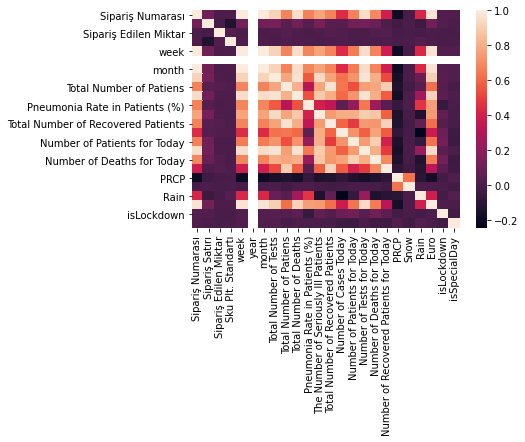

In [493]:
sns.heatmap(merged_train.corr());

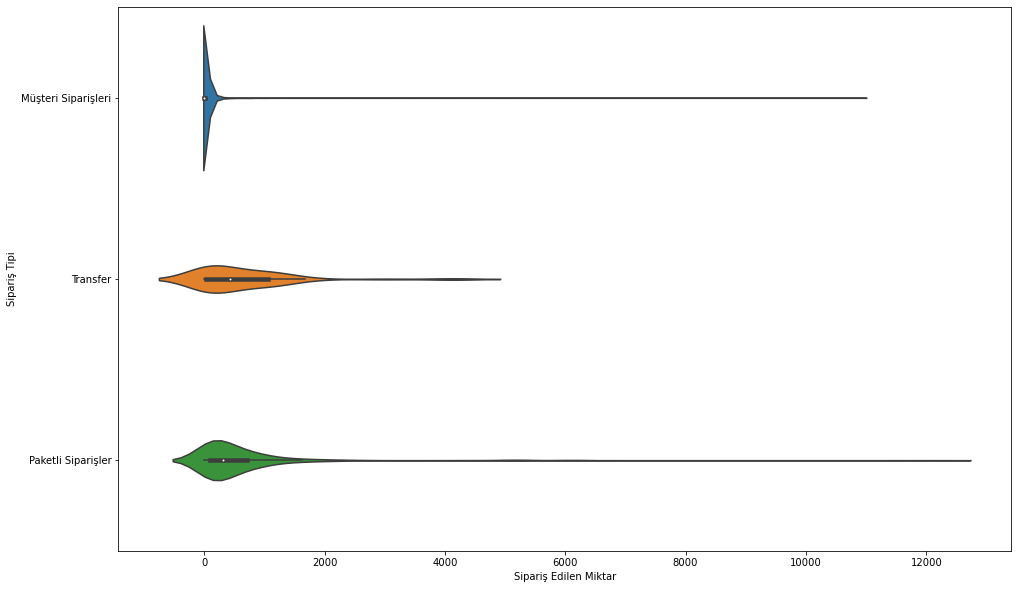

In [494]:
fig, axes = plt.subplots(figsize=(16,10))
sns.violinplot( y=merged_train['Sipariş Tipi'], x= merged_train['Sipariş Edilen Miktar'],data=merged_train)
plt.show()

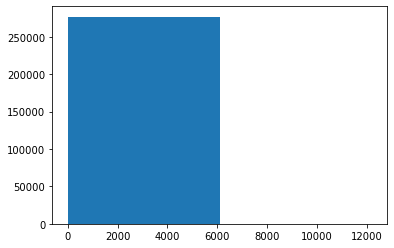

In [495]:
plt.hist(x=merged_train['Sipariş Edilen Miktar'],bins=(2))
plt.show()

<AxesSubplot:>

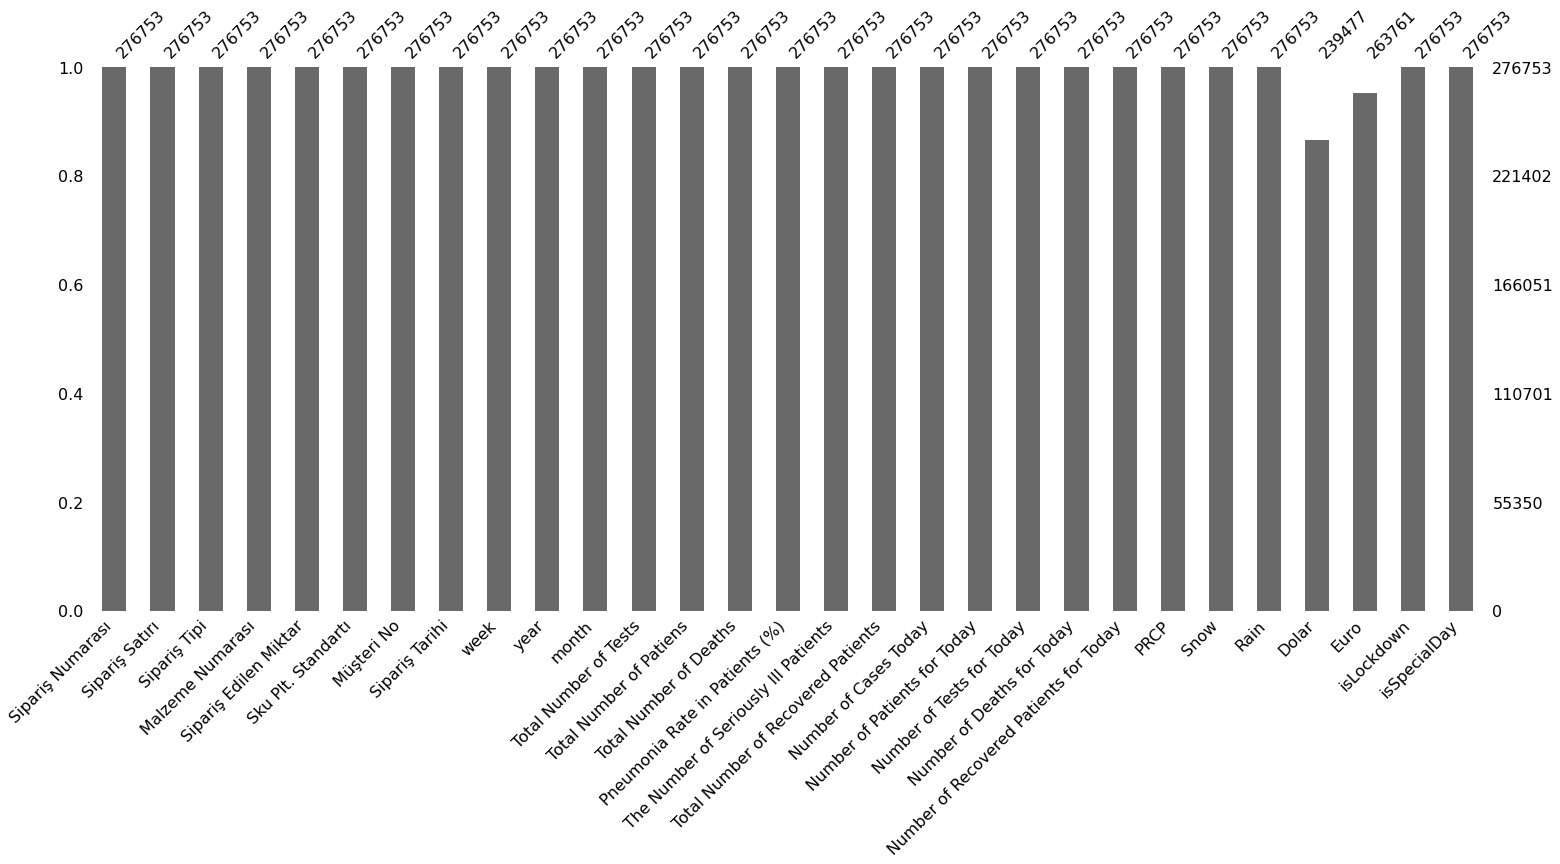

In [496]:
import missingno as msno
msno.bar(merged_train) #burda dolu olanların bar ile çizilmişi var